In [1]:
import pandas as pd
import os
import seaborn as sns
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from skbio import TreeNode
from io import StringIO
from skbio.stats.ordination import pcoa


Metaadatok beolvasása

In [2]:
path_to_metadata = 'metadata_table.txt'
meta_df = pd.read_csv(path_to_metadata, delimiter = '\t', skiprows = [1])
meta_df.head()

,#SampleID,MouseId,TSampleId,Treatment,TreatmentDate,TreatmentDateCat,TreatmentExt,MiSeqId2
0,1,Ciprofloxacin_0.1_1,1_S1,Ciprofloxacin_0.1,6/22/2018,622.0,Ciprofloxacin_0.1_622,1
1,2,Ciprofloxacin_0.1_2,2_S2,Ciprofloxacin_0.1,6/22/2018,622.0,Ciprofloxacin_0.1_622,2
2,3,Ciprofloxacin_0.1_3,3_S3,Ciprofloxacin_0.1,6/22/2018,622.0,Ciprofloxacin_0.1_622,3
3,4,Ciprofloxacin_0.1_4,4_S4,Ciprofloxacin_0.1,6/22/2018,622.0,Ciprofloxacin_0.1_622,4
4,5,Ciprofloxacin_0.1_5,5_S5,Ciprofloxacin_0.1,6/22/2018,622.0,Ciprofloxacin_0.1_622,5


Sample adatok beolvasása

Egy adott fájl feldolgozása

In [3]:
def get_data_for_sample(path_to_file):
    df = pd.read_csv(path_to_file, delimiter = '\t')
    sample_id = '_'.join(path_to_file.split('/')[-1].split('_')[0:2])
    df['TSampleId'] = sample_id
    not_found_files = set()
    try:
        df['Treatment'] = meta_df.loc[meta_df['TSampleId'] == sample_id]['Treatment'].item()
        df = df[['TSampleId', 'Treatment', 'name', 'taxonomy_lvl', 'new_est_reads', 'fraction_total_reads']]
        return df
    except: 
        #print(meta_df.loc[meta_df['TSampleId'] == sample_id]['Treatment'])
        #print("Not found file: ", sample_id)
        pass

Szükséges fájlok összegyűjtése

In [4]:
path = '//gfs/data/SE-OM/Klebsiella/trimmed_bracken/'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.txt' in file:
            files.append(os.path.join(r, file))

Fájlok beolvasása és egy dataframebe gyűjtése

In [5]:
df_list = []
for file in files:
    df = get_data_for_sample(file)
    if df is not None:
        df_list.append(get_data_for_sample(file))
df_union_all= pd.concat(df_list)

In [6]:
df_union_all.head()

,TSampleId,Treatment,name,taxonomy_lvl,new_est_reads,fraction_total_reads
0,19_S19,Ceftazidime_0.1,Muribaculaceae,F,65203,0.49823
1,19_S19,Ceftazidime_0.1,Bacteroidaceae,F,27395,0.20934
2,19_S19,Ceftazidime_0.1,Prevotellaceae,F,17232,0.13167
3,19_S19,Ceftazidime_0.1,Rikenellaceae,F,1421,0.01086
4,19_S19,Ceftazidime_0.1,Tannerellaceae,F,1595,0.01219


Alfa diverzitás számolása

Inputok: diverzitás típus, szint(P, C, F, G, S), adatok

In [7]:
def get_alpha_div(diversity_type = 'observed_otus', level = 'P', data = df_union_all):
    df_P = df_union_all.loc[df_union_all['taxonomy_lvl'] == level]
    sampleids = df_P["TSampleId"].drop_duplicates()
    names = df_P["name"].drop_duplicates()
    names = list(names)
    names.sort()
    data = []
    for sample in sampleids:
        rows = df_P.loc[df_P["TSampleId"] == sample]
        values = []
        for name in names:
            value = rows.loc[rows["name"] == name]
            if len(value) > 0:
                try:
                    values.append(int(value.new_est_reads))
                except:
                    #pass
                    values.append(int(value.new_est_reads.iloc[0]))
            else:
                values.append(0)
        data.append(values)
    ids = sampleids
    try:
        adiv_obs_otus = alpha_diversity(diversity_type, data, ids)
        meta = meta_df
        meta.index = meta["TSampleId"]
        joined = meta[["TSampleId", "MouseId", "Treatment"]].join(pd.DataFrame(adiv_obs_otus))
        joined["ADIV"] = joined[0]
        joined = joined.drop(columns=[0])
        return joined
    except:
        print("Problem when calculating " + diversity_type)

Alfa div plotolás

In [8]:
def plot_apha_div(data, diversity_type, level):
    print(diversity_type)
    print(data.head())
    plt = sns.boxplot(x="Treatment", y="ADIV", data=data)
    plt.set_xticklabels(plt.get_xticklabels(),rotation=45)
    plt.set_title("Alpha diversity with " + diversity_type + ' ' + level)
    

Különböző paraméterekkel alpha diverzitás számolása és plotolása

chao1
          TSampleId              MouseId          Treatment  ADIV
TSampleId                                                        
1_S1           1_S1  Ciprofloxacin_0.1_1  Ciprofloxacin_0.1   6.0
2_S2           2_S2  Ciprofloxacin_0.1_2  Ciprofloxacin_0.1   7.0
3_S3           3_S3  Ciprofloxacin_0.1_3  Ciprofloxacin_0.1  11.0
4_S4           4_S4  Ciprofloxacin_0.1_4  Ciprofloxacin_0.1   9.0
5_S5           5_S5  Ciprofloxacin_0.1_5  Ciprofloxacin_0.1   9.0


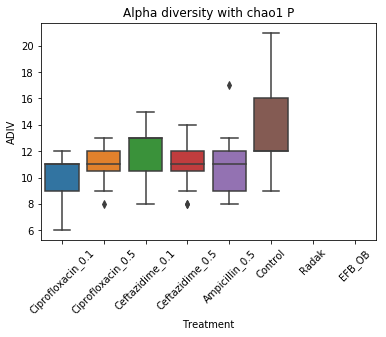

In [9]:
d1 = get_alpha_div(data = df_union_all, diversity_type = 'chao1', level = 'P')
plot_apha_div(data=d1, diversity_type='chao1', level = 'P')
d1['level'] = 'P'

shannon
          TSampleId              MouseId          Treatment      ADIV
TSampleId                                                            
1_S1           1_S1  Ciprofloxacin_0.1_1  Ciprofloxacin_0.1  1.036954
2_S2           2_S2  Ciprofloxacin_0.1_2  Ciprofloxacin_0.1  1.357908
3_S3           3_S3  Ciprofloxacin_0.1_3  Ciprofloxacin_0.1  1.465357
4_S4           4_S4  Ciprofloxacin_0.1_4  Ciprofloxacin_0.1  1.147501
5_S5           5_S5  Ciprofloxacin_0.1_5  Ciprofloxacin_0.1  0.991697


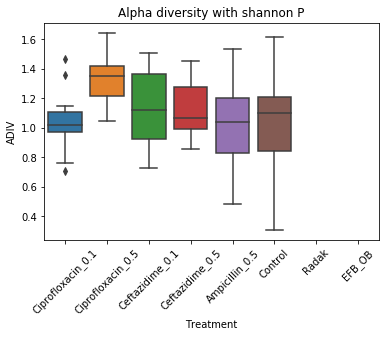

In [10]:
d2 = get_alpha_div(data = df_union_all, diversity_type = 'shannon', level = 'P')
plot_apha_div(data=d2, diversity_type='shannon', level = 'P')
d2['level'] = 'P'

shannon
          TSampleId              MouseId          Treatment      ADIV
TSampleId                                                            
1_S1           1_S1  Ciprofloxacin_0.1_1  Ciprofloxacin_0.1  1.045177
2_S2           2_S2  Ciprofloxacin_0.1_2  Ciprofloxacin_0.1  1.406116
3_S3           3_S3  Ciprofloxacin_0.1_3  Ciprofloxacin_0.1  1.519967
4_S4           4_S4  Ciprofloxacin_0.1_4  Ciprofloxacin_0.1  1.189637
5_S5           5_S5  Ciprofloxacin_0.1_5  Ciprofloxacin_0.1  1.002230


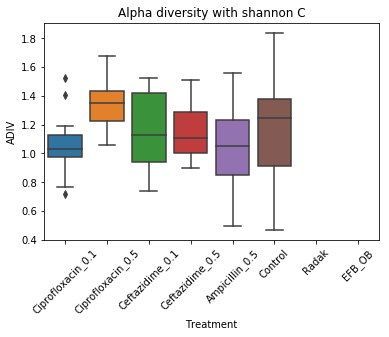

In [11]:
d3 = get_alpha_div(data = df_union_all, diversity_type = 'shannon', level = 'C')
plot_apha_div(data=d3, diversity_type='shannon', level = 'C')
d3['level'] = 'C'

shannon
          TSampleId              MouseId          Treatment      ADIV
TSampleId                                                            
1_S1           1_S1  Ciprofloxacin_0.1_1  Ciprofloxacin_0.1  1.686195
2_S2           2_S2  Ciprofloxacin_0.1_2  Ciprofloxacin_0.1  2.404293
3_S3           3_S3  Ciprofloxacin_0.1_3  Ciprofloxacin_0.1  2.619070
4_S4           4_S4  Ciprofloxacin_0.1_4  Ciprofloxacin_0.1  2.203360
5_S5           5_S5  Ciprofloxacin_0.1_5  Ciprofloxacin_0.1  2.407627


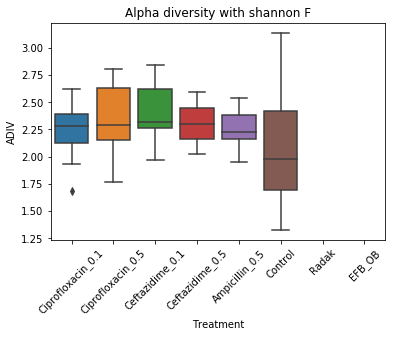

In [12]:
d4 = get_alpha_div(data = df_union_all, diversity_type = 'shannon', level = 'F')
plot_apha_div(data=d4, diversity_type='shannon', level = 'F')
d4['level'] = 'F'

Külömböző szintek együttes megjelenítése violin ploton

In [13]:
concat = pd.concat([
    d3,d4
],ignore_index=True)

In [14]:
concat.head()

,TSampleId,MouseId,Treatment,ADIV,level
0,1_S1,Ciprofloxacin_0.1_1,Ciprofloxacin_0.1,1.045177,C
1,2_S2,Ciprofloxacin_0.1_2,Ciprofloxacin_0.1,1.406116,C
2,3_S3,Ciprofloxacin_0.1_3,Ciprofloxacin_0.1,1.519967,C
3,4_S4,Ciprofloxacin_0.1_4,Ciprofloxacin_0.1,1.189637,C
4,5_S5,Ciprofloxacin_0.1_5,Ciprofloxacin_0.1,1.002230,C


In [15]:
plt = sns.boxplot(x="Treatment", y="ADIV", data=data)
plt.set_xticklabels(plt.get_xticklabels(),rotation=45)
plt.set_title("Alpha diversity with " + diversity_type + ' ' + level)

NameError: name 'data' is not defined

In [ ]:
plt = sns.violinplot(x="Treatment", y="ADIV", hue="level",
               split=True, inner="quart",
               data=concat)
plt.set_xticklabels(plt.get_xticklabels(),rotation=45)

In [18]:
import skbio.diversity as diversity
import matplotlib.pyplot as plt

divlist = diversity.get_alpha_diversity_metrics()

In [16]:
def plot_apha_div_v2(data, diversity_type, level):
    #print(diversity_type)
    #print(data.head())
    
    fig, ax = plt.subplots()
    #fig.set_size_inches(14, 5)
    try:
        ax =  sns.boxplot(x="Treatment", y="ADIV", data=data)
        plt.xticks(rotation=65)
        ax.set_title("Alpha diversity with " + diversity_type + ' ' + level)
        plt.show()
    except:
        print("Problem occured in " + diversity_type)

In [17]:
for div in divlist:
    d = get_alpha_div(data = df_union_all, diversity_type = div, level = 'F')
    plot_apha_div_v2(data=d, diversity_type=div, level = 'F')

NameError: name 'divlist' is not defined

Braycurtis béta diverzitás számolása és megjelenítése

Paraméterek: adat, szint, kontrol(benne legyenek-e a kontroll minták)

In [19]:
def beta_div(data, level, control = True):
    df_P = data.loc[df_union_all['taxonomy_lvl'] == level]
    df = df_P
    if not control:
        df = df_P.loc[df_P["Treatment"] != 'Control']
    sampleids = df["TSampleId"].drop_duplicates()
    names = df["name"].drop_duplicates()
    names = list(names)
    names.sort()
    data = []
    for sample in sampleids:
        rows = df.loc[df["TSampleId"] == sample]
        values = []
        for name in names:
            value = rows.loc[rows["name"] == name]
            if len(value) > 0:
                try:
                    values.append(int(value.new_est_reads))
                except:
                    #pass
                    values.append(int(value.new_est_reads.iloc[0]))
            else:
                values.append(0)
        data.append(values)
    ids = sampleids

    bc_dm = beta_diversity("braycurtis", data, ids)
    bc_pc = pcoa(bc_dm)
    bc_pc.plot(sample_md, 'Treatment',
                      axis_labels=('PC 1', 'PC 2', 'PC 3'),
                      title='Samples colored by treatment, ' + level, s = 50)

Különböző paraméterekkel béta diverzitás számolása és plotolása

In [20]:
beta_div(data = df_union_all, level = 'P')

/gfs/progs/miniconda3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.4691376255475142 and the largest is 5.996214928907659.
  RuntimeWarning


NameError: name 'sample_md' is not defined

/gfs/progs/miniconda3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.1709082810111762 and the largest is 1.5441401029416728.
  RuntimeWarning


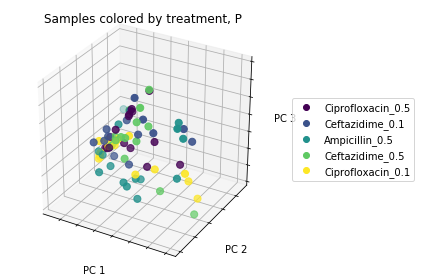

In [148]:
beta_div(data = df_union_all, level = 'P', control = False)

/gfs/progs/miniconda3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.3785426307493574 and the largest is 5.989319714239462.
  RuntimeWarning


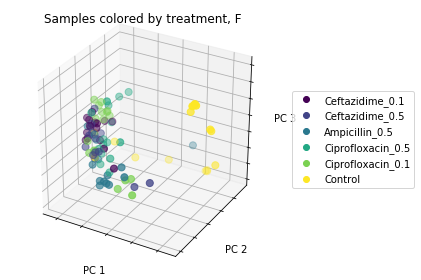

In [149]:
beta_div(data = df_union_all, level = 'F', control = True)

/gfs/progs/miniconda3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.2196701778338957 and the largest is 3.852039003966807.
  RuntimeWarning


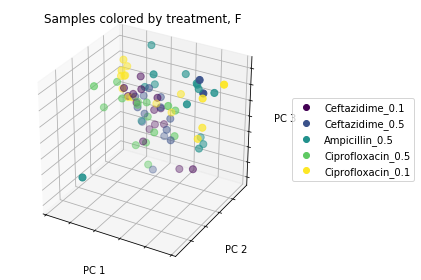

In [150]:
beta_div(data = df_union_all, level = 'F', control = False)

/gfs/progs/miniconda3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.31227271067624557 and the largest is 5.293713394674391.
  RuntimeWarning


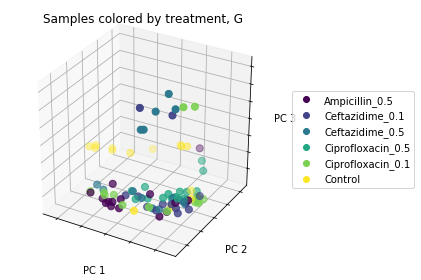

In [151]:
beta_div(data = df_union_all, level = 'G', control = True)

/gfs/progs/miniconda3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.1907812328823256 and the largest is 4.234158226390612.
  RuntimeWarning


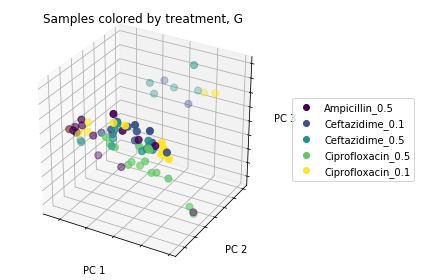

In [152]:
beta_div(data = df_union_all, level = 'G', control = False)

In [22]:
df_union_all.head()

,TSampleId,Treatment,name,taxonomy_lvl,new_est_reads,fraction_total_reads
0,19_S19,Ceftazidime_0.1,Muribaculaceae,F,65203,0.49823
1,19_S19,Ceftazidime_0.1,Bacteroidaceae,F,27395,0.20934
2,19_S19,Ceftazidime_0.1,Prevotellaceae,F,17232,0.13167
3,19_S19,Ceftazidime_0.1,Rikenellaceae,F,1421,0.01086
4,19_S19,Ceftazidime_0.1,Tannerellaceae,F,1595,0.01219


In [44]:
data = df_union_all.loc[df_union_all['taxonomy_lvl'] == 'C']
pivot = data.pivot(index='TSampleId', columns='name', values="new_est_reads")


In [30]:
pivot.fillna(0).head()

name,Acidimicrobiia,Acidobacteriia,Actinobacteria,Alphaproteobacteria,Anaerolineae,BRH-c20a,Babeliae,Bacilli,Bacteroidia,Berkelbacteria,...,Planctomycetacia,Rhodothermia,Saccharimonadia,Spirochaetia,Synergistia,Thermoplasmata,V2072-189E03,Verrucomicrobiae,WWE3,vadinHA49
TSampleId,,,,,,,,,,,,,,,,,,,,,
10_S10,0,0,137,138,22,0,0,52,108501,0,...,0,0,0,0,0,0,0,24925,0,0
11_S11,0,39,165,99,41,0,0,110,127458,0,...,0,30,0,0,0,0,0,18288,0,0
12_S12,0,26,213,134,28,0,0,73,118357,0,...,0,0,0,0,0,0,0,10632,0,0
13_S13,0,0,188,198,35,0,0,74,81257,0,...,20,0,0,22,0,0,0,10788,0,0
14_S14,0,39,185,124,40,0,0,124,124054,0,...,41,0,0,34,0,0,0,14972,0,0


In [46]:
target = data[["TSampleId","Treatment"]].drop_duplicates()
#data = pd.merge(pivot, target,  how='left', left_on=['TSampleId'], right_on = ['TSampleId'])
joined = target.join(pivot)

In [48]:
target.head()

,TSampleId,Treatment
0,15_S15,Ceftazidime_0.1
0,21_S21,Ceftazidime_0.1
0,28_S28,Ceftazidime_0.5
0,34_S34,Ampicillin_0.5
0,18_S18,Ceftazidime_0.1


In [49]:
pivot.head()

name,Acidimicrobiia,Acidobacteriia,Actinobacteria,Alphaproteobacteria,Anaerolineae,BRH-c20a,Babeliae,Bacilli,Bacteroidia,Berkelbacteria,...,Planctomycetacia,Rhodothermia,Saccharimonadia,Spirochaetia,Synergistia,Thermoplasmata,V2072-189E03,Verrucomicrobiae,WWE3,vadinHA49
TSampleId,,,,,,,,,,,,,,,,,,,,,
10_S10,NaN,NaN,137,138,22,NaN,NaN,52,108501,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24925,NaN,NaN
11_S11,NaN,39,165,99,41,NaN,NaN,110,127458,NaN,...,NaN,30,NaN,NaN,NaN,NaN,NaN,18288,NaN,NaN
12_S12,NaN,26,213,134,28,NaN,NaN,73,118357,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10632,NaN,NaN
13_S13,NaN,NaN,188,198,35,NaN,NaN,74,81257,NaN,...,20,NaN,NaN,22,NaN,NaN,NaN,10788,NaN,NaN
14_S14,NaN,39,185,124,40,NaN,NaN,124,124054,NaN,...,41,NaN,NaN,34,NaN,NaN,NaN,14972,NaN,NaN


In [51]:
target.index = target["TSampleId"]

In [52]:
joined = target.join(pivot)

In [53]:
joined.head()

,TSampleId,Treatment,Acidimicrobiia,Acidobacteriia,Actinobacteria,Alphaproteobacteria,Anaerolineae,BRH-c20a,Babeliae,Bacilli,...,Planctomycetacia,Rhodothermia,Saccharimonadia,Spirochaetia,Synergistia,Thermoplasmata,V2072-189E03,Verrucomicrobiae,WWE3,vadinHA49
TSampleId,,,,,,,,,,,,,,,,,,,,,
15_S15,15_S15,Ceftazidime_0.1,NaN,NaN,79,50,NaN,NaN,NaN,73,...,23,NaN,NaN,27,NaN,NaN,NaN,12822,NaN,NaN
21_S21,21_S21,Ceftazidime_0.1,NaN,NaN,71,50,NaN,NaN,NaN,53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9163,NaN,NaN
28_S28,28_S28,Ceftazidime_0.5,NaN,NaN,97,139,34,NaN,NaN,472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,NaN,NaN
34_S34,34_S34,Ampicillin_0.5,NaN,NaN,66,53,NaN,NaN,NaN,57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN
18_S18,18_S18,Ceftazidime_0.1,NaN,NaN,87,96,49,NaN,20,77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17667,NaN,NaN


In [58]:
joined = joined.fillna(0)
joined["Target"] = joined['Treatment']
joined = joined.drop(columns=["Treatment", "TSampleId"])

In [59]:
X = joined.drop(columns=["Target"])
y = joined["Target"]

In [61]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 

# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
  
# training a DescisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions) 

In [62]:
cm

array([[3, 2, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [1, 4, 0, 0, 0, 0],
       [1, 6, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0]])

In [67]:
len(joined)

91

In [69]:
joined.size

4732